### Importing required libraries

In [ ]:
# General Utilities
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

# Kaggle
import kagglehub

# OpenCV for Image Processing
import cv2

# Scikit-learn for Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K

# Data Augmentation
import albumentations as A

### Downloading the Dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("vbookshelf/pneumothorax-chest-xray-images-and-masks")

print("Path to dataset files:", path)

100%|██████████| 4.50G/4.50G [02:16<00:00, 35.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/versions/2


### Listing Dataset Files

In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/versions/2"

for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    for file in files[:5]:  # Show first 5 files per folder
        print(f"{file}")


Directory: /root/.cache/kagglehub/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/versions/2
Directory: /root/.cache/kagglehub/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/versions/2/siim-acr-pneumothorax
stage_1_test_images.csv
stage_1_train_images.csv
Directory: /root/.cache/kagglehub/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/versions/2/siim-acr-pneumothorax/png_images
1280_train_1_.png
562_train_1_.png
9153_train_0_.png
5724_train_0_.png
5704_train_0_.png
Directory: /root/.cache/kagglehub/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/versions/2/siim-acr-pneumothorax/png_masks
1280_train_1_.png
562_train_1_.png
9153_train_0_.png
5724_train_0_.png
5704_train_0_.png


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/versions/2/siim-acr-pneumothorax"

# Search for CSV files
for file in os.listdir(dataset_path):
    if file.endswith(".csv"):
        print("Found CSV file:", file)


Found CSV file: stage_1_test_images.csv
Found CSV file: stage_1_train_images.csv


In [ ]:
# Define paths
csv_train_path = dataset_path + "/stage_1_train_images.csv"
csv_test_path = dataset_path + "/stage_1_test_images.csv"

# Read CSV files
train_df = pd.read_csv(csv_train_path)
test_df = pd.read_csv(csv_test_path)

# Display first few rows
print("Train CSV:")
print(train_df.head())

print("\nTest CSV:")
print(test_df.head())


Train CSV:
     new_filename                                            ImageId  \
0  0_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...   
1  1_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...   
2  2_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   
3  3_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   
4  4_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.1314.151787516...   

   has_pneumo  
0           0  
1           0  
2           1  
3           1  
4           1  

Test CSV:
    new_filename                                            ImageId  \
0  0_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5797.151787519...   
1  1_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5798.151787519...   
2  2_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5799.151787519...   
3  3_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.580.1517875163...   
4  4_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5800.151787519...   

   has_pneumo  
0     

In [ ]:
# Define dataset paths
dataset_path = "/root/.cache/kagglehub/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/versions/2/siim-acr-pneumothorax"
image_dir = os.path.join(dataset_path, "png_images")
mask_dir = os.path.join(dataset_path, "png_masks")

# Get sorted file paths
image_paths = sorted(glob(os.path.join(image_dir, "*.png")))
mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))

print(f"Total Images: {len(image_paths)}, Total Masks: {len(mask_paths)}")


Total Images: 12047, Total Masks: 12047


In [ ]:
# Check if first few images and masks match
for i in range(5):
    print(f"Image: {os.path.basename(image_paths[i])}  ↔  Mask: {os.path.basename(mask_paths[i])}")


Image: 0_test_1_.png  ↔  Mask: 0_test_1_.png
Image: 0_train_0_.png  ↔  Mask: 0_train_0_.png
Image: 10000_train_0_.png  ↔  Mask: 10000_train_0_.png
Image: 10001_train_0_.png  ↔  Mask: 10001_train_0_.png
Image: 10002_train_0_.png  ↔  Mask: 10002_train_0_.png


### Filtering Images and Masks

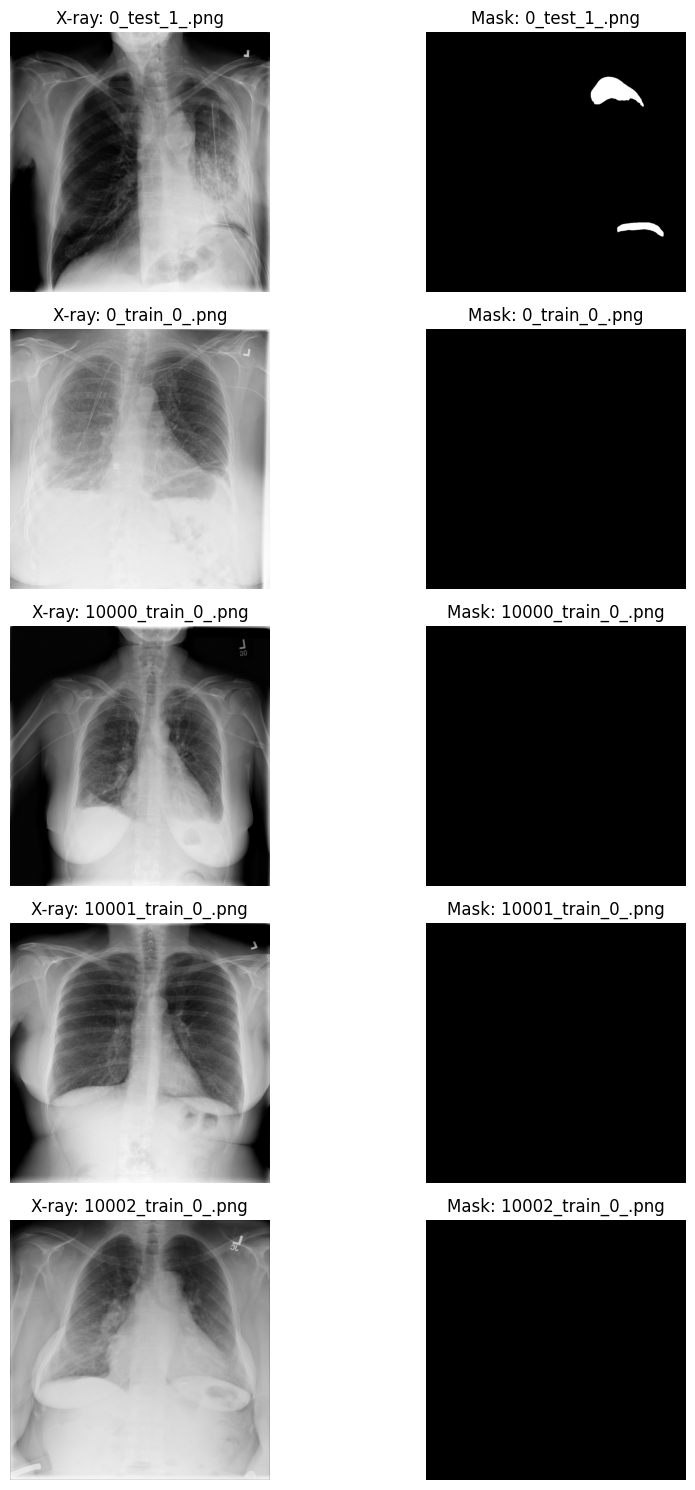

In [ ]:
# Define image and mask directories
image_folder = dataset_path + "/png_images"
mask_folder = dataset_path + "/png_masks"

# First five images and masks
sample_images = ["0_test_1_.png", "0_train_0_.png", "10000_train_0_.png", "10001_train_0_.png", "10002_train_0_.png"]

# Create subplots
fig, axes = plt.subplots(len(sample_images), 2, figsize=(10, 15))

for i, img_name in enumerate(sample_images):
    img_path = os.path.join(image_folder, img_name)
    mask_path = os.path.join(mask_folder, img_name)

    # Read images
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Display X-ray image
    axes[i, 0].imshow(img, cmap="gray")
    axes[i, 0].set_title(f"X-ray: {img_name}")
    axes[i, 0].axis("off")

    # Display corresponding mask
    axes[i, 1].imshow(mask, cmap="gray")
    axes[i, 1].set_title(f"Mask: {img_name}")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# Count masks with disease vs no disease
mask_counts = [np.sum(cv2.imread(os.path.join(mask_folder, img), cv2.IMREAD_GRAYSCALE) > 0) > 0 for img in sample_images]

print("Number of X-rays with disease regions:", sum(mask_counts))
print("Number of X-rays with no disease:", len(mask_counts) - sum(mask_counts))


Number of X-rays with disease regions: 1
Number of X-rays with no disease: 4


### X-ray Image with Mask Overlay

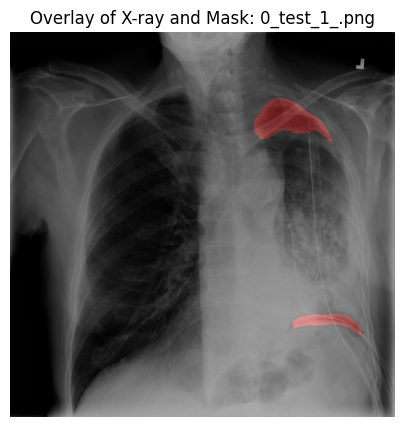

In [ ]:
# Define image and mask directories
image_folder = dataset_path + "/png_images"
mask_folder = dataset_path + "/png_masks"

# Select the sample image that has a mask
sample_image_name = "0_test_1_.png"  # Change if needed
image_path = os.path.join(image_folder, sample_image_name)
mask_path = os.path.join(mask_folder, sample_image_name)

# Load images
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Convert mask to red overlay
colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
colored_mask[mask > 0] = [255, 0, 0]  # Red color for the mask

# Merge X-ray with the mask overlay
overlay = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), 0.7, colored_mask, 0.3, 0)

# Display the overlay
plt.figure(figsize=(5, 5))
plt.imshow(overlay)
plt.title(f"Overlay of X-ray and Mask: {sample_image_name}")
plt.axis("off")
plt.show()


In [ ]:
print("Train CSV Info:")
print(train_df.info())

print("\nUnique Image Counts in Train Set:", train_df['ImageId'].nunique())


Train CSV Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10675 entries, 0 to 10674
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   new_filename  10675 non-null  object
 1   ImageId       10675 non-null  object
 2   has_pneumo    10675 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 250.3+ KB
None

Unique Image Counts in Train Set: 10675


In [ ]:
# Load CSV file
csv_path = os.path.join(dataset_path, "stage_1_train_images.csv")  # Change for test set if needed
df = pd.read_csv(csv_path)

# Display dataset info
print("CSV File Info:")
print(df.head())
print("\nMissing Values:", df.isnull().sum())


CSV File Info:
     new_filename                                            ImageId  \
0  0_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...   
1  1_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...   
2  2_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   
3  3_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   
4  4_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.1314.151787516...   

   has_pneumo  
0           0  
1           0  
2           1  
3           1  
4           1  

Missing Values: new_filename    0
ImageId         0
has_pneumo      0
dtype: int64


### Preprocessing: Image and Mask

In [ ]:
IMG_SIZE = 256  # Resize to 256x256

def preprocess_image(img_path):
    """Load image, resize, and normalize."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize
    return img

def preprocess_mask(mask_path):
    """Load mask, resize, and normalize."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = mask / 255.0  # Normalize (binary mask)
    return mask

# Test preprocessing on one image
sample_img = os.path.join(image_folder, "0_test_1_.png")
sample_mask = os.path.join(mask_folder, "0_test_1_.png")

processed_img = preprocess_image(sample_img)
processed_mask = preprocess_mask(sample_mask)

print("Processed Image Shape:", processed_img.shape)
print("Processed Mask Shape:", processed_mask.shape)


Processed Image Shape: (256, 256)
Processed Mask Shape: (256, 256)


In [ ]:
# Get image-mask pairs
image_paths = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder)])
mask_paths = sorted([os.path.join(mask_folder, img) for img in os.listdir(mask_folder)])

# Split into train and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

print(f"Training Samples: {len(train_images)}, Validation Samples: {len(val_images)}")


Training Samples: 9637, Validation Samples: 2410


### Custom Data Generator for Image Segmentation

In [ ]:
class DataGenerator(Sequence):
    """Custom data generator for loading images and masks in batches."""
    def __init__(self, image_list, mask_list, batch_size=16):
        self.image_list = image_list
        self.mask_list = mask_list
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.image_list[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_list[index * self.batch_size:(index + 1) * self.batch_size]

        images = np.array([preprocess_image(img) for img in batch_images])
        masks = np.array([preprocess_mask(mask) for mask in batch_masks])

        return images, masks

# Create train and validation generators
train_gen = DataGenerator(train_images, train_masks)
val_gen = DataGenerator(val_images, val_masks)


### Data Augmentation for Image Segmentation

In [ ]:
# Define augmentation pipeline
augmentations = A.Compose([
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    A.GridDistortion(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Resize(256, 256)
])

class DataGenerator(Sequence):
    """Custom Data Generator with Augmentation."""
    def __init__(self, image_list, mask_list, batch_size=16, augment=False):
        self.image_list = image_list
        self.mask_list = mask_list
        self.batch_size = batch_size
        self.augment = augment  # Enable or disable augmentation

    def __len__(self):
        return int(np.ceil(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.image_list[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_list[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        masks = []

        for img_path, mask_path in zip(batch_images, batch_masks):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load X-ray
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load Mask

            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))

            # Normalize
            img = img / 255.0
            mask = mask / 255.0
            mask = np.expand_dims(mask, axis=-1)  # Ensure correct shape

            if self.augment:
                augmented = augmentations(image=img, mask=mask)
                img, mask = augmented["image"], augmented["mask"]

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

# Create train and validation generators with augmentation
train_gen = DataGenerator(train_images, train_masks, augment=True)
val_gen = DataGenerator(val_images, val_masks, augment=False)

print("Data Augmentation Applied Successfully!")

Data Augmentation Applied Successfully!


<ipython-input-15-7bf30ca933ed>:11: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


### U-Net Model for Image Segmentation

In [ ]:
def unet_model(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model

# Create U-Net model
model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

### Optimized Training with Mixed Precision & Custom Loss

In [ ]:
# Set Mixed Precision for Faster Training on GPU
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Improved Dice Coefficient Function
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')

    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

# Improved Loss Function (Higher Dice Loss Weight)
def combined_loss(y_true, y_pred):
    dice = 1 - dice_coefficient(y_true, y_pred)  # Dice Loss
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)  # Binary Crossentropy
    return (1.5 * dice) + (0.5 * bce)  # More weight on Dice Loss

# Compile Model with Optimized Settings
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR for stable training
    loss=combined_loss,
    metrics=[dice_coefficient, 'binary_accuracy']  # Show accuracy in logs
)

#  Add Early Stopping & ReduceLROnPlateau (Faster Convergence)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

#  Train Model (Increased Steps Per Epoch for Faster Learning)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    steps_per_epoch=300,  #  More training steps per epoch
    validation_steps=50,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 263s 840ms/step - binary_accuracy: 0.9918 - dice_coefficient: 0.0714 - loss: 1.4182 - val_binary_accuracy: 0.9910 - val_dice_coefficient: 0.0987 - val_loss: 1.3761 - learning_rate: 1.0000e-04
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 261s 869ms/step - binary_accuracy: 0.9935 - dice_coefficient: 0.0768 - loss: 1.4044 - val_binary_accuracy: 0.9934 - val_dice_coefficient: 0.0942 - val_loss: 1.3796 - learning_rate: 1.0000e-04
Epoch 3/20
  3/300 ━━━━━━━━━━━━━━━━━━━━ 3:54 788ms/step - binary_accuracy: 0.9897 - dice_coefficient: 0.0540 - loss: 1.4548

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - binary_accuracy: 0.9892 - dice_coefficient: 0.0603 - loss: 1.4460 - val_binary_accuracy: 0.9904 - val_dice_coefficient: 0.0961 - val_loss: 1.3771 - learning_rate: 1.0000e-04
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - binary_accuracy: 0.9921 - dice_coefficient: 0.0815 - loss: 1.3976
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
300/300 ━━━━━━━━━━━━━━━━━━━━ 276s 829ms/step - binary_accuracy: 0.9921 - dice_coefficient: 0.0815 - loss: 1.3976 - val_binary_accuracy: 0.9961 - val_dice_coefficient: 0.0487 - val_loss: 1.4381 - learning_rate: 1.0000e-04
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 262s 873ms/step - binary_accuracy: 0.9938 - dice_coefficient: 0.0961 - loss: 1.3735 - val_binary_accuracy: 0.9906 - val_dice_coefficient: 0.1143 - val_loss: 1.3485 - learning_rate: 5.0000e-05
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - binary_accuracy: 0.9905 - dice_coefficient: 0.0563 - loss: 1.4364 - val_bi

In [ ]:
best_epoch = 9  # Choose the best epoch
model.set_weights(history.model.get_weights())  # Restore weights

### Saving the U-Net Model

In [ ]:
model.save("best_model_epoch9.h5")


In [ ]:
keras.saving.save_model(model, "best_model_epoch9.keras")

### Loading & Visualizing Model Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


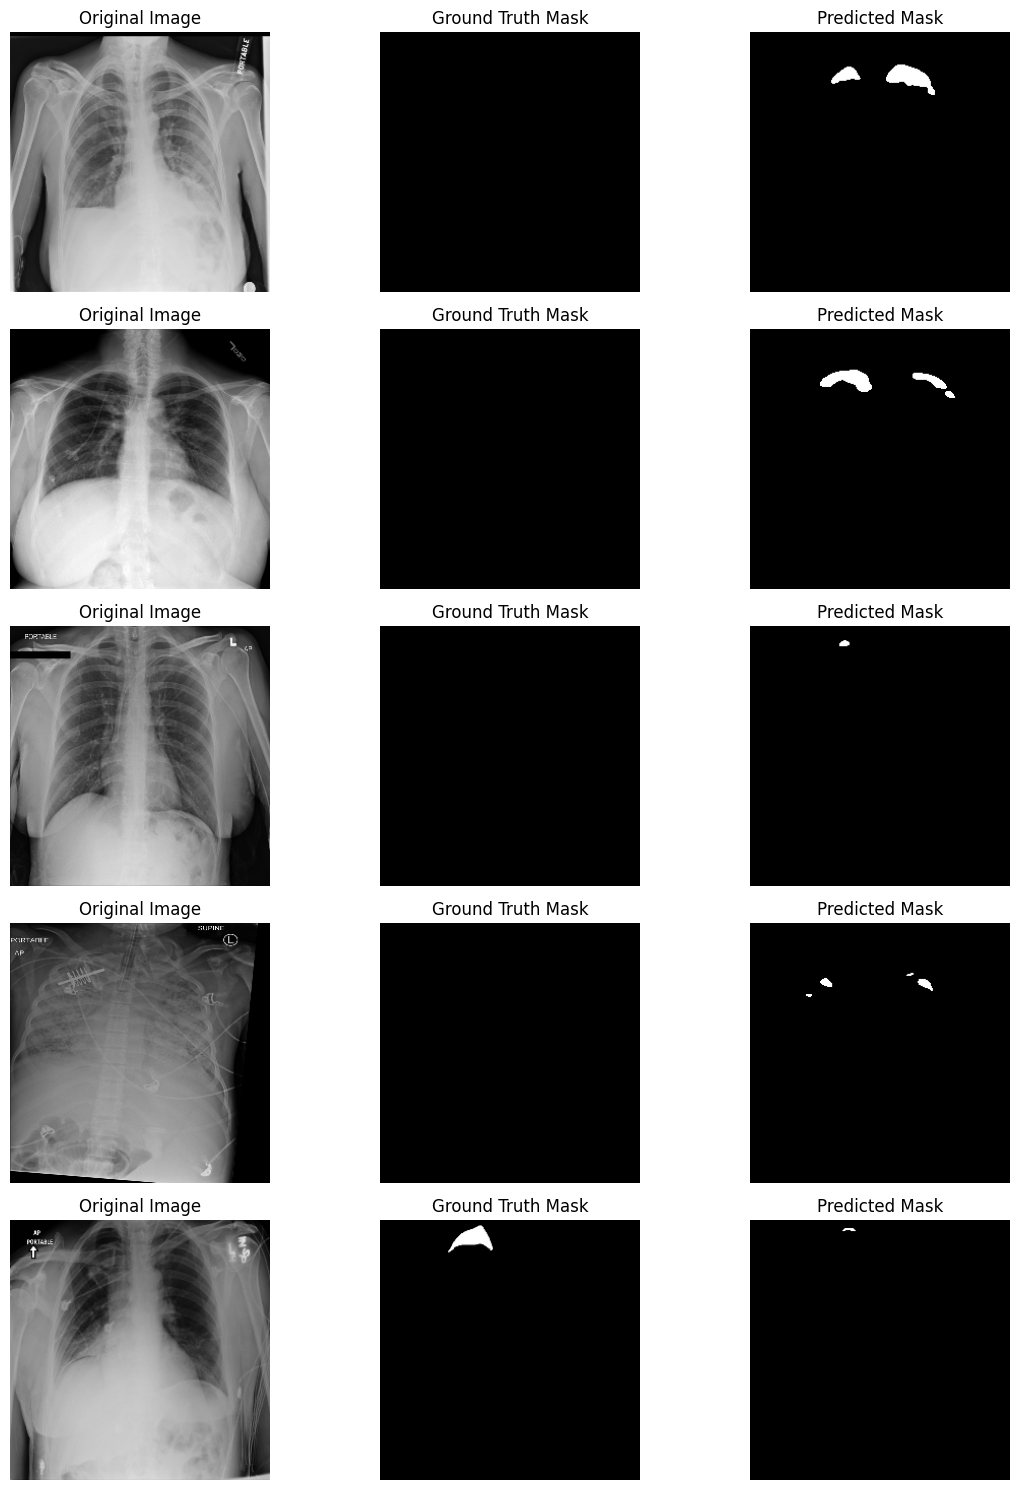

In [ ]:
# Load the trained model
model = load_model("best_model_epoch9.keras", compile=False)  # Use .h5 if needed

# Select a few validation images
num_samples = 5  # Adjust as needed
val_iter = iter(val_gen)  # Convert DataGenerator to an iterator
val_images, val_masks = next(val_iter)  # Load a batch

# Make predictions
pred_masks = model.predict(val_images)

# Threshold predictions (convert to binary masks)
threshold = 0.3
pred_masks_bin = (pred_masks > threshold).astype(np.uint8)


# Function to plot images and masks
def plot_predictions(images, true_masks, pred_masks, num_samples=5):
    plt.figure(figsize=(12, num_samples * 3))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_masks[i], cmap="gray")
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_masks[i], cmap="gray")
        plt.title("Predicted Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Plot results
plot_predictions(val_images, val_masks, pred_masks_bin, num_samples)


In [ ]:
print("Unique values in masks:", np.unique(val_masks))


Unique values in masks: [0.         0.25098039 0.50196078 0.74901961 1.        ]


### Evaluating Model Performance: Dice Coefficient & IoU

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Compute metrics
dice_scores = [dice_coefficient(val_masks[i], pred_masks_bin[i]) for i in range(num_samples)]
iou_scores = [iou(val_masks[i], pred_masks_bin[i]) for i in range(num_samples)]

print("Dice Scores:", dice_scores)
print("IoU Scores:", iou_scores)


Dice Scores: [1.075268816048098e-09, 1.1337868467870898e-09, 2.5641024983563464e-08, 6.060606023875115e-09, 0.055318935279694496]
IoU Scores: [1.075268816048098e-09, 1.1337868467870898e-09, 2.5641024983563464e-08, 6.060606023875115e-09, 0.028446277425528018]


In [ ]:
num_non_empty_masks = sum([np.any(mask > 0) for mask in val_masks])
print(f"Non-empty masks in batch: {num_non_empty_masks}/{len(val_masks)}")

Non-empty masks in batch: 2/16


### Model Improvement / Fine Tuning

In [ ]:
# Define augmentation pipeline
augmentations = A.Compose([
    A.Rotate(limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HorizontalFlip(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),
    A.GridDistortion(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
    A.Resize(256, 256)
])

class DataGenerator(Sequence):
    """Custom Data Generator with Augmentation and Proper Preloading."""
    def __init__(self, image_list, mask_list, batch_size=16, augment=False, preload=False):
        self.image_list = image_list
        self.mask_list = mask_list
        self.batch_size = batch_size
        self.augment = augment
        self.preload = preload

        # Preload data into memory (if enabled)
        if self.preload:
            print("Preloading data into memory...")
            self.image_list = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in self.image_list]
            self.mask_list = [cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in self.mask_list]

    def __len__(self):
        return int(np.ceil(len(self.image_list) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.image_list[index * self.batch_size:(index + 1) * self.batch_size]
        batch_masks = self.mask_list[index * self.batch_size:(index + 1) * self.batch_size]

        images, masks = [], []

        for img, mask in zip(batch_images, batch_masks):
            # If data is not preloaded, read from disk
            if not isinstance(img, np.ndarray):
                img = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
                mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

            # Ensure valid images and masks
            if img is None or mask is None:
                print("Warning: Image or mask not found!")
                continue

            # Apply augmentation if enabled
            if self.augment:
                augmented = augmentations(image=img, mask=mask)
                img, mask = augmented["image"], augmented["mask"]

            # Resize and normalize
            img = cv2.resize(img, (256, 256)).astype(np.float32) / 255.0
            mask = cv2.resize(mask, (256, 256)).astype(np.float32)

            # Ensure proper shape
            img = np.expand_dims(img, axis=-1)  # Shape: (256, 256, 1)
            mask = np.expand_dims((mask > 0.5).astype(np.float32), axis=-1)  # Binarize & reshape

            images.append(img)
            masks.append(mask)

        images = np.array(images)
        masks = np.array(masks)

        # **Fix last batch size issue**
        return images, masks

# Create Generators
train_gen = DataGenerator(train_images, train_masks, augment=True, preload=False)
val_gen = DataGenerator(val_images, val_masks, augment=False, preload=False)

<ipython-input-74-7c1dddeb4b64>:11: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.3),


In [ ]:
print("First image path:", train_images[0])
print("First mask path:", train_masks[0])

First image path: /root/.cache/kagglehub/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/versions/2/siim-acr-pneumothorax/png_images/1058_test_1_.png
First mask path: /root/.cache/kagglehub/datasets/vbookshelf/pneumothorax-chest-xray-images-and-masks/versions/2/siim-acr-pneumothorax/png_masks/1058_test_1_.png


In [ ]:
sample_images, sample_masks = next(iter(train_gen))
print("Train batch shape:", sample_images.shape, sample_masks.shape)

Train batch shape: (16, 256, 256, 1) (16, 256, 256, 1)


In [ ]:
num_non_empty_masks = sum([np.any(mask > 0) for mask in sample_masks])
print(f"Non-empty masks in batch: {num_non_empty_masks}/{len(sample_masks)}")


Non-empty masks in batch: 7/16


In [ ]:
# Step 1: Define Dice Loss Function
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Step 2: Load Pretrained Model
model = load_model("best_model_epoch9.keras", compile=False)

# Step 3: Compile Model for Fine-Tuning
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=["accuracy"])

print(" Model Loaded and Compiled for Fine-Tuning!")

 Model Loaded and Compiled for Fine-Tuning!


### Visualizing Segmentation Results

In [ ]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stopping])

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 565s 936ms/step - accuracy: 0.9931 - loss: 0.8688 - val_accuracy: 0.9983 - val_loss: 1.0000
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 584s 967ms/step - accuracy: 0.9923 - loss: 0.8639 - val_accuracy: 0.9983 - val_loss: 1.0000
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 546s 905ms/step - accuracy: 0.9970 - loss: 0.9991 - val_accuracy: 0.9983 - val_loss: 1.0000
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 555s 920ms/step - accuracy: 0.9971 - loss: 0.9890 - val_accuracy: 0.9983 - val_loss: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


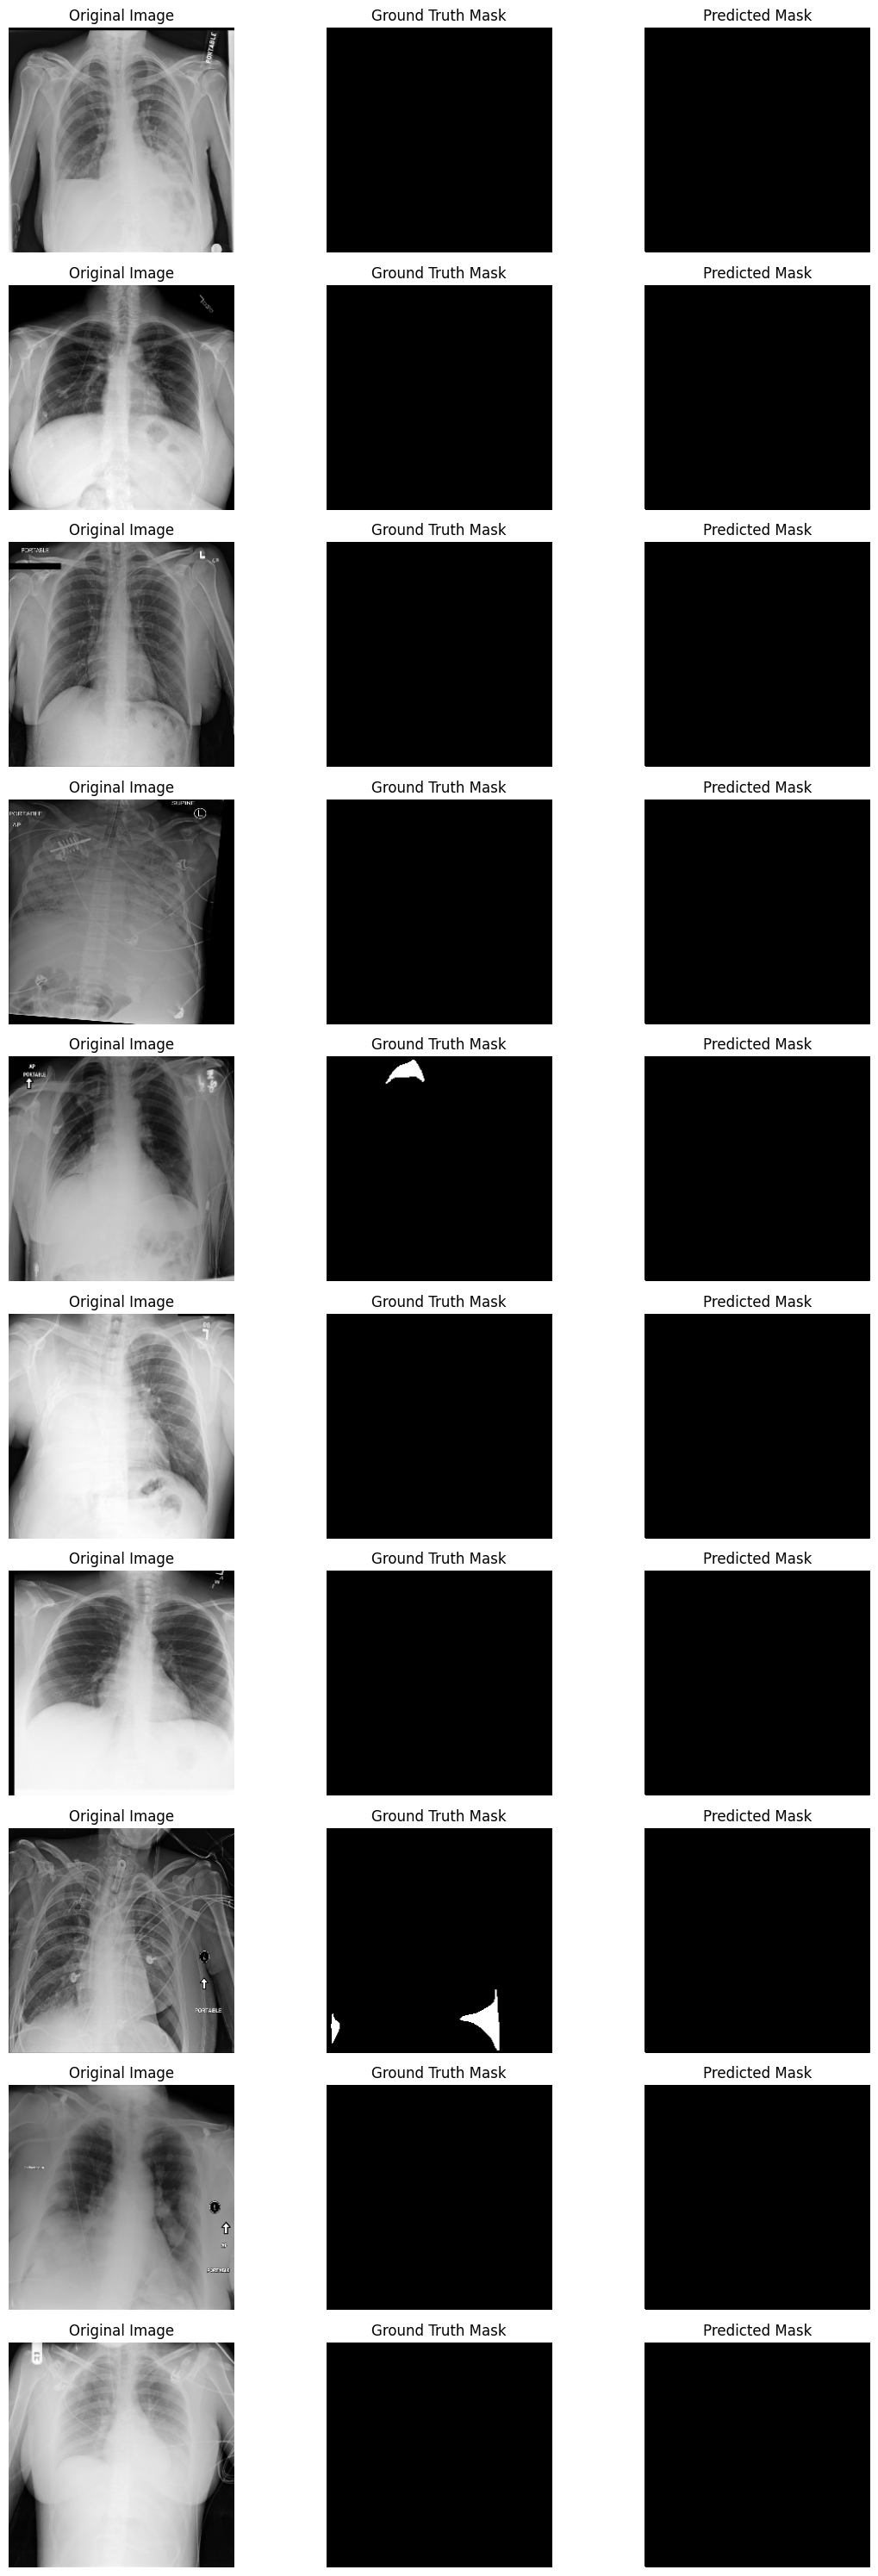

In [ ]:
# Select a few images from the validation set
num_samples = 10  # Number of images to visualize
val_images, val_masks = next(iter(val_gen))  # Get a batch

# Predict using the model
pred_masks = model.predict(val_images)

# Plot original images, ground truth masks, and predicted masks
fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))

for i in range(num_samples):
    axes[i, 0].imshow(val_images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title("Original Image")

    axes[i, 1].imshow(val_masks[i].squeeze(), cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")

    axes[i, 2].imshow(pred_masks[i].squeeze(), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
print("Shape of val_images:", val_images.shape)
print("Shape of val_masks:", val_masks.shape)
print("Type of val_images:", type(val_images))
print("First element type:", type(val_images[0]) if len(val_images) > 0 else "Empty")

Shape of val_images: (1, 256, 256, 1)
Shape of val_masks: (1, 256, 256, 1)
Type of val_images: <class 'numpy.ndarray'>
First element type: <class 'numpy.ndarray'>


### Randomly Selecting and Visualizing Validation Samples

Shape of val_images: (10, 256, 256, 1)
Shape of val_masks: (10, 256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step


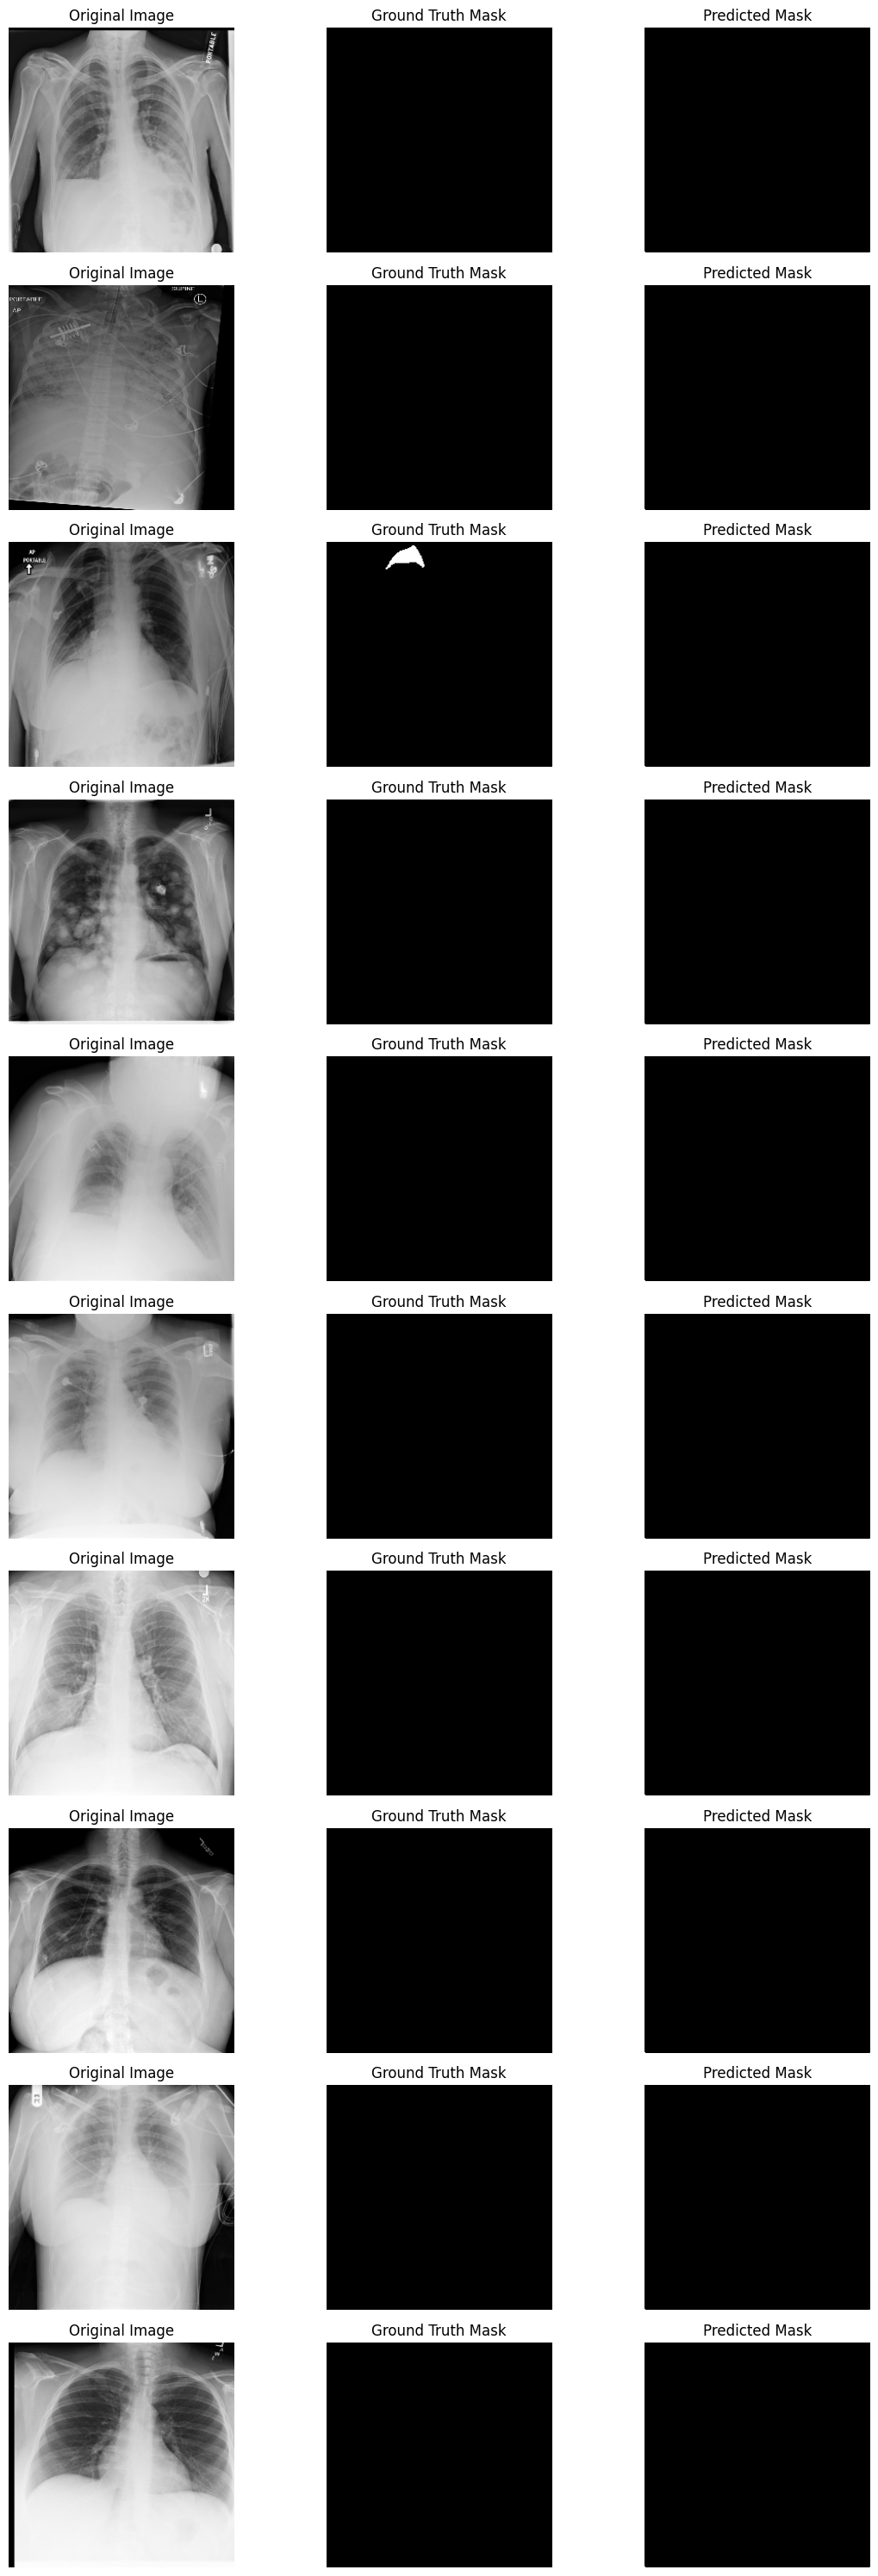

In [ ]:
# Ensure we don't exceed available batches
total_batches = len(val_gen)
num_samples = min(10, total_batches * val_gen.batch_size)  # Ensure we have enough images

# Store images & masks
val_images = []
val_masks = []

while len(val_images) < num_samples:  # Keep collecting until we reach the target
    batch_idx = random.randint(0, total_batches - 1)  # Pick a random batch index
    batch = val_gen[batch_idx]

    if isinstance(batch, tuple) and len(batch) == 2:
        batch_images, batch_masks = batch
    else:
        raise ValueError(f"val_gen[{batch_idx}] did not return a tuple! Got {type(batch)}")

    # Ensure batch_images has samples
    if len(batch_images.shape) != 4 or batch_images.shape[0] == 0:
        continue  # Skip empty batches

    # Select random indices from batch
    available_samples = batch_images.shape[0]
    num_to_select = min(num_samples - len(val_images), available_samples)  # Fill remaining slots
    selected_indices = random.sample(range(available_samples), num_to_select)

    # Append selected images & masks
    val_images.extend(batch_images[selected_indices])
    val_masks.extend(batch_masks[selected_indices])

# Convert lists to numpy arrays
val_images = np.array(val_images)
val_masks = np.array(val_masks)

# Ensure correct dimensions before prediction
print("Shape of val_images:", val_images.shape)  # Should be (num_samples, 256, 256, 1)
print("Shape of val_masks:", val_masks.shape)

# Predict using the model
pred_masks = model.predict(val_images)

# Plot original images, ground truth masks, and predicted masks
fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 3))

for i in range(num_samples):
    axes[i, 0].imshow(val_images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title("Original Image")

    axes[i, 1].imshow(val_masks[i].squeeze(), cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")

    axes[i, 2].imshow(pred_masks[i].squeeze(), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")

    for ax in axes[i]:
        ax.axis("off")

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


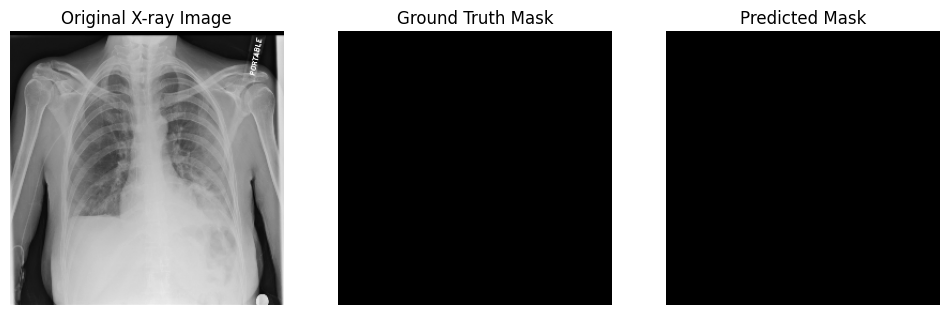

In [ ]:
# Load your trained model (Update the path if needed)
model = load_model("best_model_epoch9.keras", compile=False)

# Get a single batch from the validation generator
images, true_masks = val_gen[0]  # Get first batch

# Select the first image & mask from the batch
image = images[0]  # Shape: (256, 256, 1)
true_mask = true_masks[0]  # Shape: (256, 256, 1)

# Make prediction
pred_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Remove batch dimension
pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize prediction

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title("Original X-ray Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step


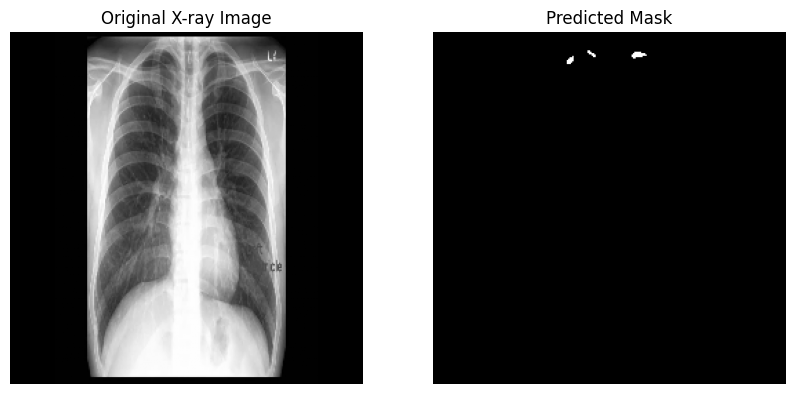

In [ ]:
# Load the trained model
model = load_model("best_model_epoch9.keras", compile=False)  # Update with your actual model path

# Function to preprocess the image
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale

    if img is None:
        raise ValueError(f"Error: Could not load image from path '{image_path}'. Check file path.")

    img = cv2.resize(img, target_size)  # Resize
    img = img.astype(np.float32) / 255.0  # Normalize
    img = np.expand_dims(img, axis=-1)  # Add channel dimension (H, W, 1)
    img = np.expand_dims(img, axis=0)  # Add batch dimension (1, H, W, 1)
    return img

# Function to make predictions
def predict_mask(image_path):
    img = preprocess_image(image_path)
    pred_mask = model.predict(img)[0]  # Get first output (remove batch dimension)
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Binarize mask
    return img[0, :, :, 0], pred_mask[:, :, 0]  # Remove extra dimensions for visualization

image_path = "/content/maxresdefault.jpg"

# Run prediction
try:
    original_image, predicted_mask = predict_mask(image_path)

    # Plot results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original X-ray Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

except ValueError as e:
    print(e)

In [ ]:
print("Current working directory:", os.getcwd())
print("Available files:", os.listdir())

Current working directory: /content
Available files: ['.config', 'best_model_epoch9.keras', 'maxresdefault.jpg', 'best_model_epoch9.h5', '3fEn9BhrsCcN1UgqfOqbQm9bxGAMWaUAFuhTHV4w0GEDScdnxT16g3FA4gHW99yg81irAW6RRh5J2vAS9JFItMfCJslu9OunQAChZj4AkopvxCw9a4HZhjhuSMsG.webp', 'sample_data']


In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = y_true.flatten()
    y_pred = (y_pred.flatten() > 0.5).astype(np.uint8)  # Binarize prediction

    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

# Example Usage
images, true_masks = val_gen[0]  # Get a batch
pred_masks = model.predict(images)

# Compute Dice for each image & average
dice_scores = [dice_coefficient(true_masks[i], pred_masks[i]) for i in range(len(images))]
mean_dice = np.mean(dice_scores)
print(f"Mean Dice Score: {mean_dice:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Mean Dice Score: 0.8750


In [ ]:
def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = y_true.flatten()
    y_pred = (y_pred.flatten() > 0.5).astype(np.uint8)

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Compute IoU for a batch
iou_scores = [iou_score(true_masks[i], pred_masks[i]) for i in range(len(images))]
mean_iou = np.mean(iou_scores)
print(f"Mean IoU Score: {mean_iou:.4f}")


Mean IoU Score: 0.8750


In [ ]:
def compute_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = (y_pred.flatten() > 0.5).astype(np.uint8)

    precision = precision_score(y_true, y_pred, zero_division=1)
    recall = recall_score(y_true, y_pred, zero_division=1)
    f1 = f1_score(y_true, y_pred, zero_division=1)

    return precision, recall, f1

# Compute metrics for the batch
metrics = [compute_metrics(true_masks[i], pred_masks[i]) for i in range(len(images))]
mean_precision = np.mean([m[0] for m in metrics])
mean_recall = np.mean([m[1] for m in metrics])
mean_f1 = np.mean([m[2] for m in metrics])

print(f"Precision: {mean_precision:.4f}")
print(f"Recall: {mean_recall:.4f}")
print(f"F1 Score: {mean_f1:.4f}")


Precision: 1.0000
Recall: 0.8750
F1 Score: 0.8750


In [ ]:
def pixel_accuracy(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = (y_pred.flatten() > 0.5).astype(np.uint8)

    return np.mean(y_true == y_pred)

# Compute Accuracy for the batch
pixel_accs = [pixel_accuracy(true_masks[i], pred_masks[i]) for i in range(len(images))]
mean_pixel_acc = np.mean(pixel_accs)
print(f"Pixel-wise Accuracy: {mean_pixel_acc:.4f}")

Pixel-wise Accuracy: 0.9983
